In [1]:
# https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-knystxwh because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Prepare Dataset
# load data
train = pd.read_csv(r"./rnn_data/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

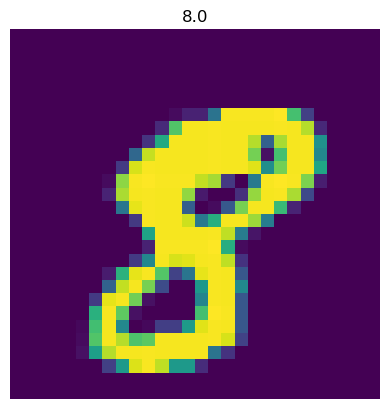

In [5]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
# plt.savefig('graph.png')
plt.show()

In [6]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 2.2815935611724854  Accuracy: 17.321428298950195 %
Iteration: 1000  Loss: 1.5901100635528564  Accuracy: 53.21428680419922 %
Iteration: 1500  Loss: 0.7407814860343933  Accuracy: 80.1547622680664 %
Iteration: 2000  Loss: 0.3497272729873657  Accuracy: 84.11904907226562 %
Iteration: 2500  Loss: 0.25889459252357483  Accuracy: 90.35713958740234 %
Iteration: 3000  Loss: 0.35412707924842834  Accuracy: 82.58333587646484 %
Iteration: 3500  Loss: 0.7026528120040894  Accuracy: 77.10713958740234 %
Iteration: 4000  Loss: 0.4629836976528168  Accuracy: 89.53571319580078 %
Iteration: 4500  Loss: 0.4321271777153015  Accuracy: 93.86904907226562 %
Iteration: 5000  Loss: 0.12956342101097107  Accuracy: 94.45237731933594 %
Iteration: 5500  Loss: 0.30077049136161804  Accuracy: 90.0952377319336 %
Iteration: 6000  Loss: 0.22170378267765045  Accuracy: 95.25 %
Iteration: 6500  Loss: 0.07162202894687653  Accuracy: 95.86904907226562 %
Iteration: 7000  Loss: 0.21486730873584747  Accuracy: 94.61

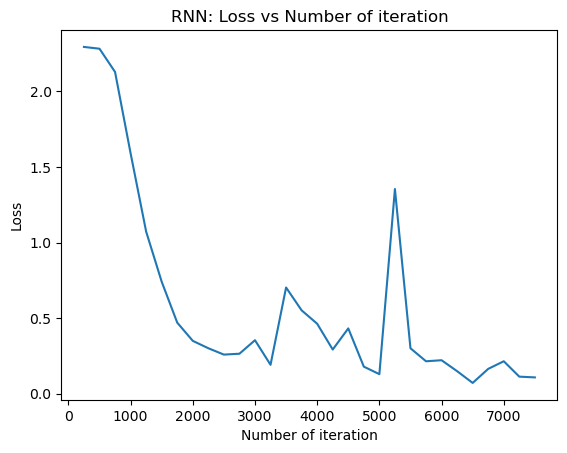

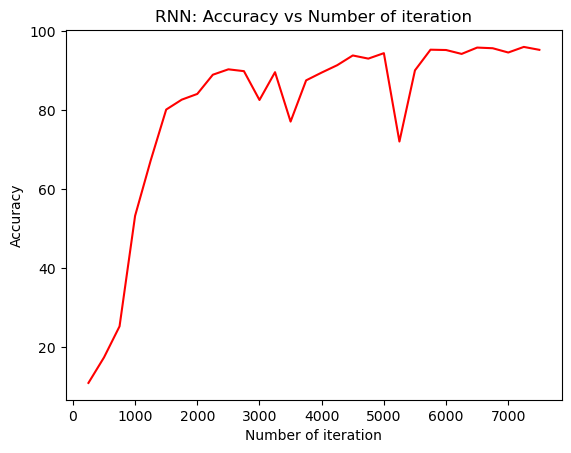

In [8]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
# plt.savefig('graph.png')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

compute_device = 'cpu'

# Define the continuous-time dynamics function
class ContinuousTimeDynamics(nn.Module):
    def __init__(self):
        super(ContinuousTimeDynamics, self).__init__()
        self.W = nn.Parameter(torch.randn(100, 100) * 0.1).to(compute_device)  # Recurrent connectivity matrix
        self.tanh = nn.Tanh()

    def forward(self, x):
        dxdt = torch.matmul(self.tanh(x.to(compute_device)), self.W)
        return dxdt

# Define the RNN model
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.dynamics = ContinuousTimeDynamics()
        self.noise = nn.Parameter(torch.randn(100) * 0.01)  # Noise term
        self.external_input = nn.Parameter(torch.randn(100) * 0.1)  # Random external input

    def forward(self, timesteps):
        h = torch.zeros(100).to(compute_device)  # Initial hidden state
        outputs = []

        for _ in range(timesteps):
            h = h + self.dynamics(h) + self.noise + self.external_input
            outputs.append(h)

        return torch.stack(outputs)

# Generate random input and target time series
input_sequence = torch.randn(500, 100).to(compute_device)  # Random input time series
target_sequence = torch.randn(500, 100).to(compute_device)  # Random target time series

# Initialize the RNN model
model = RNN().to(compute_device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    output_sequence = model(500)  # Generate output sequence
    loss = criterion(output_sequence, target_sequence)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

print("Training complete!")


KeyboardInterrupt: 

In [ ]:
# https://colab.research.google.com/github/gyyang/nn-brain/blob/master/RNN_tutorial.ipynb#scrollTo=coupled-sessions

Typical **continuous-time recurrent neural networks** equation:

\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

Then we discretize this network in time using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} &= \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)] \\
    &= (1 - \frac{\Delta t}{\tau})\mathbf{r}(t) + \frac{\Delta t}{\tau}f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)
\end{align}

In [ ]:
class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

In [ ]:
class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output